# 08 Example - Optimization Scan Using Gradient Descent-Based Subclass Implemented from `AbstractOptimizeScan`

In [1]:
import pyscan as ps
import numpy as np
import matplotlib.pyplot as plt

## Setup devices

In [2]:
devices = ps.ItemAttribute()

devices.v1 = ps.TestVoltage() # Device 1
devices.v2 = ps.TestVoltage() # Device 2

## Define a measure function

In [3]:
def voltage_response(v1, v2):
        return (v1 - 4)**2 + (v2 - 6)**2

def get_voltage_data(expt):
    """
    Reads the voltage from v1, v2, and v3 devices. Also adds a calculated value vsum.
    """

    runinfo = expt.runinfo
    devices = expt.devices

    d = ps.ItemAttribute()

    d.v1_readout = devices.v1.voltage
    d.v2_readout = devices.v2.voltage

    d.vf = voltage_response(d.v1_readout, d.v2_readout)
    
    return d

# Define live plot

In [4]:
@ps.live_plot
def plot_optim_live(expt):
    global fig, ax, cb0, cb1
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                cmap='viridis')
    ax.set_box_aspect(1)
    if cb0 is None and cb1 is None:
        cb0 = fig.colorbar(scatter, label="optimizer step")
        cb1 = fig.colorbar(pcm, label="voltage response")
    else:
        cb0.update_normal(scatter)
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

# Define runinfo

In [5]:
runinfo = ps.RunInfo()
runinfo.measure_function = get_voltage_data

# Implement `GradientDescentOptimizeScan`: `AbstractOptimizeScan` subclass

In [6]:
class GradientDescentOptimizeScan(ps.AbstractOptimizeScan):

    def __init__(self, initialization_dict, prop, optimizer_inputs, sample_function_output,
                 input_epsilon, learning_rate, update_epsilon,
                 iteration_max=100, dt=0):
        super().__init__(initialization_dict, prop, optimizer_inputs, sample_function_output,
                         iteration_max=iteration_max, dt=dt)
        self.dim = 0
        self.fd_step = True
        self.input_epsilon = input_epsilon
        self.learning_rate = learning_rate
        self.update_epsilon = update_epsilon
        self.dim_ct = len(optimizer_inputs)
        self.keep_running = np.full(self.dim_ct, True)
    
    def step_optimizer(self, index, experiment):
        
        def gd_f(f_in_prev, f_out, f_out_prev, input_epsilon, learning_rate):
            grad = (f_out - f_out_prev) / input_epsilon
            grad_update = learning_rate * grad
            f_in_dim_next = f_in_prev - grad_update
            return grad, f_in_dim_next

        if self.fd_step:
            f_in = [experiment.__dict__[measurement][index - 1] for measurement in self.opt_in]
            f_in[self.dim] += self.input_epsilon[self.dim]
            self.fd_step = False
            return f_in
        else:
            f_in_prev = [experiment.__dict__[measurement][index - 2] for measurement in self.opt_in]
            f_out = experiment.__dict__[self.sample_f_out][index - 1]
            f_out_prev = experiment.__dict__[self.sample_f_out][index - 2]
            grad_dim, f_in_next_dim = gd_f(f_in_prev[self.dim], f_out, f_out_prev, self.input_epsilon[self.dim], self.learning_rate[self.dim])
            f_in_next = f_in_prev.copy()
            f_in_next[self.dim] = f_in_next_dim
            self.keep_running[self.dim] = abs(grad_dim) > self.update_epsilon[self.dim]
            if not self.keep_running.any():
                self.running = False
            self.fd_step = True
            self.dim += 1
            self.dim %= self.dim_ct
            return f_in_next


# Instantiate OptimizeScan

In [7]:
runinfo.scan0 = GradientDescentOptimizeScan({'v1': 2., 'v2': 1.}, 'voltage', ('v1_readout', 'v2_readout'), 'vf',
                                            (1e-1, 1e-1), (1e-1, 1e-1), (1e-1, 1e-1),
                                            iteration_max=100, dt=1.)

# Run Experiments

In [8]:
expt = ps.Experiment(runinfo, devices, time=True)
expt.start_thread()

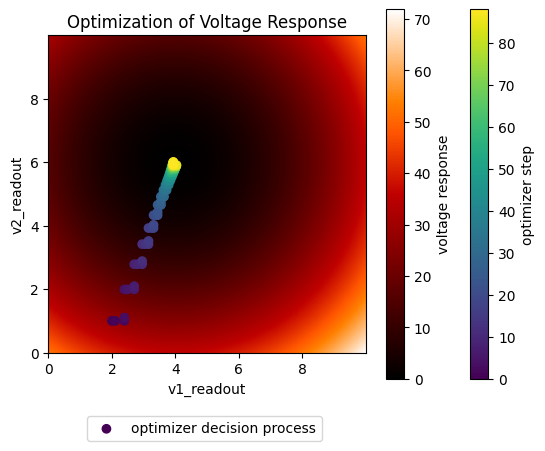

In [9]:
fig, ax = plt.subplots()
cb0 = cb1 = None
try:
    plot_optim_live(expt)
except KeyboardInterrupt:
    expt.stop()

In [10]:
expt.__dict__

{'runinfo': <pyscan.measurement.run_info.RunInfo at 0x262f97cbcb0>,
 'devices': <pyscan.general.item_attribute.ItemAttribute at 0x262f97cb8c0>,
 'expt_thread': <Thread(Thread-3 (run), stopped daemon 61132)>,
 'v1_voltage': array([2.        , 2.1       , 2.39      , 2.39      , 2.39      ,
        2.49      , 2.702     , 2.702     , 2.702     , 2.802     ,
        2.9516    , 2.9516    , 2.9516    , 3.0516    , 3.15128   ,
        3.15128   , 3.15128   , 3.25128   , 3.311024  , 3.311024  ,
        3.311024  , 3.411024  , 3.4388192 , 3.4388192 , 3.4388192 ,
        3.5388192 , 3.54105536, 3.54105536, 3.54105536, 3.64105536,
        3.62284429, 3.62284429, 3.62284429, 3.72284429, 3.68827543,
        3.68827543, 3.68827543, 3.78827543, 3.74062034, 3.74062034,
        3.74062034, 3.84062034, 3.78249628, 3.78249628, 3.78249628,
        3.88249628, 3.81599702, 3.81599702, 3.81599702, 3.91599702,
        3.84279762, 3.84279762, 3.84279762, 3.94279762, 3.86423809,
        3.86423809, 3.86423809

In [11]:
# ps.live_plot2D(expt, data_name="vf") # TODO: remove empty values from v1_voltage and v2_voltage

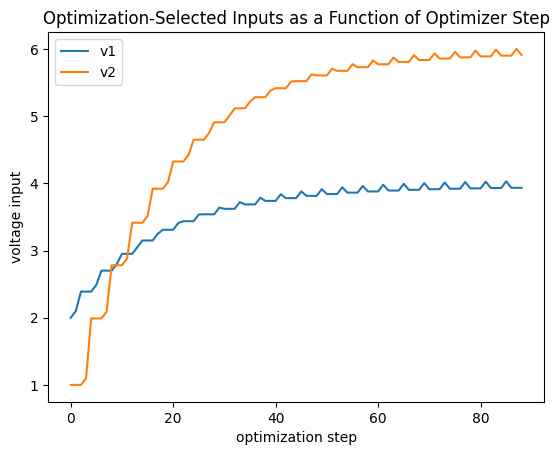

In [12]:
plt.plot(list(zip(expt.v1_readout, expt.v2_readout)))
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

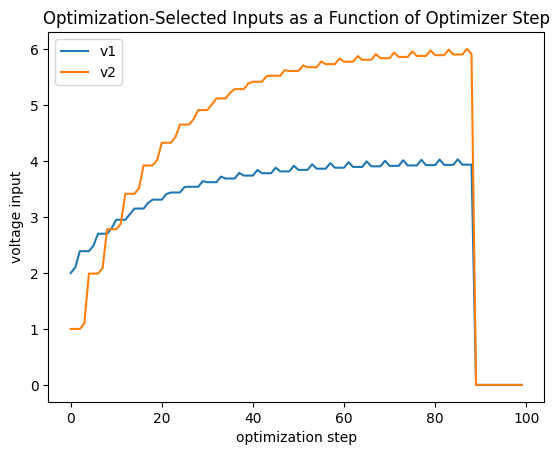

In [13]:
plt.plot(list(zip(expt.v1_voltage, expt.v2_voltage))) # TODO: trim unused inputs from scan dict?
plt.legend(['v1', 'v2'])
plt.xlabel("optimization step")
plt.ylabel("voltage input")
plt.title("Optimization-Selected Inputs as a Function of Optimizer Step");

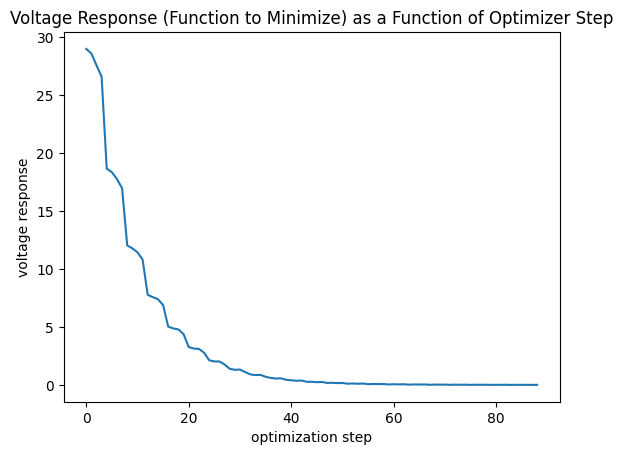

In [14]:
plt.plot(expt.vf)
plt.xlabel("optimization step")
plt.ylabel("voltage response")
plt.title("Voltage Response (Function to Minimize) as a Function of Optimizer Step");

In [15]:
def plot_optim_pcm():
    fig, ax = plt.subplots()
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    pcm = ax.pcolormesh(x, y, z, cmap='gist_heat')
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, c=range(len(expt.v1_readout)),
                         cmap='viridis')
    ax.set_box_aspect(1)
    fig.colorbar(scatter, label="optimizer step")
    fig.colorbar(pcm, label="voltage response")
    ax.legend(["optimizer decision process",], loc='lower left', bbox_to_anchor=(.1, -.3))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_title("Optimization of Voltage Response")

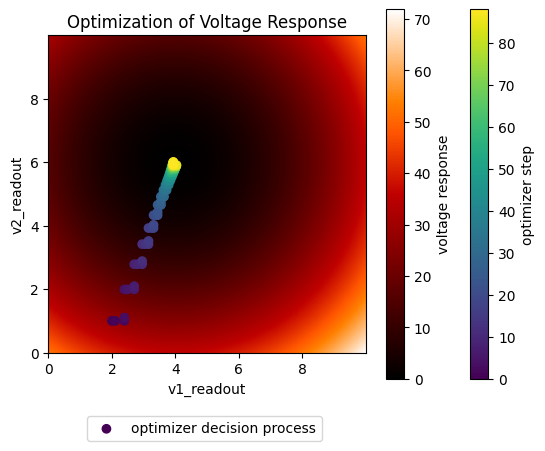

In [16]:
plot_optim_pcm()

In [17]:
def plot_optim_3d(elevation, azimuth):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x, y = np.mgrid[0:10:.01, 0:10:.01]
    z = np.array(voltage_response(np.ravel(x), np.ravel(y)))
    z = z.reshape(x.shape)
    ax.plot_surface(x, y, z, color='C1', alpha=.5)
    scatter = ax.scatter(expt.v1_readout, expt.v2_readout, expt.vf, c=range(len(expt.v1_readout)))
    ax.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(scatter, label="optimizer step", pad=.1)
    ax.legend(["voltage response function", "optimizer decision process",], loc='lower left', bbox_to_anchor=(.2, -.2))
    ax.set_xlabel("v1_readout")
    ax.set_ylabel("v2_readout")
    ax.set_zlabel("voltage response")
    ax.set_title("Optimization of Voltage Response")

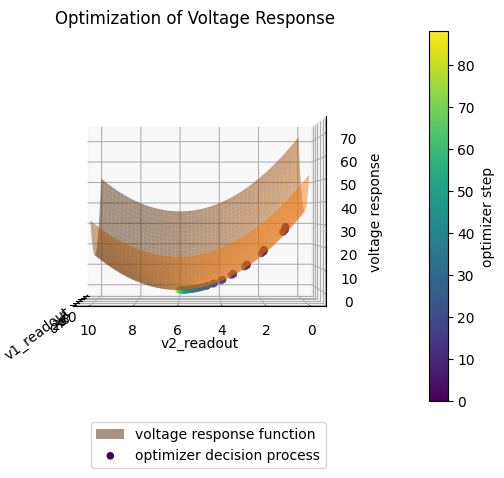

In [18]:
plot_optim_3d(0, 180)

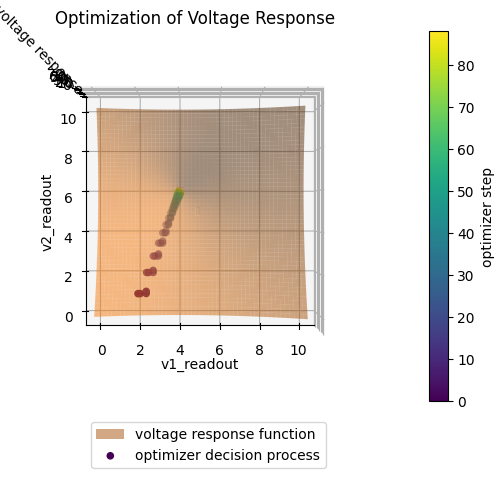

In [19]:
plot_optim_3d(90, 270)

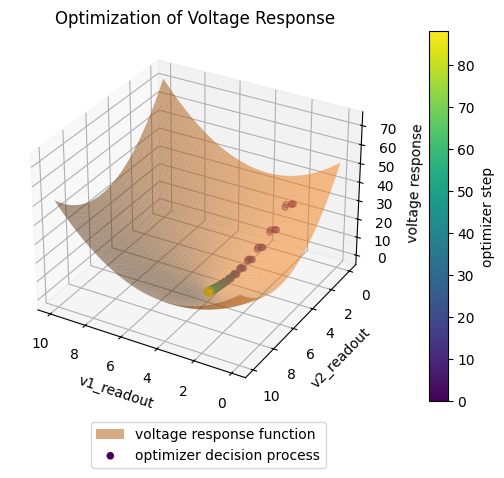

In [20]:
plot_optim_3d(30, 120)